# <span style="color:blue">Esercitazione 7</span>

### Esercizio 07.1

In questo esercizio sfrutto lo studio tramite MCMC methods di un *sistema canonico* (numero di particelle $N$, volume $V$ e temperatura $T$ fissati) in *periodic boundary condition* (sistema di bulk, limite termodinamico) come esempio per analizzare l'equilibrazione e l'autocorrelazione di una catena di Markov e per capire come stimare una corretta lunghezza dei blocchi in cui suddividere le misure (*blocking method*) per poter effettivamente applicare su di esse il CLT ed evitare quindi una sottistima dell'incertezza statistica dei risultati finali. Il sistema è studiato nelle condizioni termodinamiche di:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (raggio di cut-off: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (raggio di cut-off: $r_c = 2.5$)
2. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (raggio di cut-off: $r_c = 5.0$)

Per fare questo ho simulato con l'*algoritmo di Metropolis* una catena di Markov di $M=5\times10^5$ passi a seguito di un'equilibrazione di $M_{eq}=10^4$ step, e in ognuna delle configurazioni visitate ho valutato i valori istantanei di energia potenziale per particella $U/N$ e di pressione $P$ (corretti con le rispettive *tail corrections*).\
La probabilità di transizione di prova $T(\vec{x}|\vec{y})$ dell'algoritmo è stata scelta uniforme e di larghezza $\Delta$ tale da rispettare approssimativamente la "regola" dell'accettazione al $50\%$. Per il gas in realtà questo non è possibile, nel senso che anche con $\Delta \sim L_{box}/2$, con $L_{box} \sim 13\ \sigma$ (unità di Lennard-Jones) lato del box in cui sono contenute le particelle, si riesce a scendere non sotto un'accettazione media di $\langle A \rangle \simeq 62\%$. Questo non è un problema qui, nel senso che è in qualche modo la fisica del sistema a tenere alta l'accettazione, la quale non indica quindi una bassa efficienza nell'esplorazione dello spazio delle configurazioni. Il gas infatti è poco denso, e quindi è statisticamente facile riuscire a muovere le particelle e modificarne le posizioni. Questo porta, tra l'altro, a configurazioni che si scorrelano molto in fretta, come si vedrà esplicitamente nei successivi grafici di ${Ac}(t)$.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl

nburn=int(np.genfromtxt('results/burnin.solid.epot.ist',max_rows=1))   #step for burn-in
nstep=int(np.genfromtxt('results/output.solid.epot.ist',max_rows=1))   #step for simulation
nstp=(3000,3000)   #graphs will represent nstp[0] first and nstp[1] last steps
lab_state=['solid','liquid','gas']; title_burn=('First','Last')
title=['Potential energy','Pressure']

I grafici che seguono mostrano, per i tre stati, la fase di burn-in e la serie di misurazioni raccolte dopo di essa. Tutto è rappresentato in unità di Lennard-Jones.

In [2]:
def graph_burn(meas, ifburn):   #meas is "epot" or "pres"
    label=lab_state.copy(); tit=title.copy()
    if ifburn:
        name='burnin'; tit=', burn-in'
        head=(1,nburn-nstp[1]); max_r=(nstp[0],nburn)  #genfromtxt parameters
    else:
        name='output'; tit=', simulation'
        head=(1,nstep-nstp[1]); max_r=(nstp[0],nstep)
    
    pl.figure(figsize=(15,5))
    for i in range(2):
        obs_s=np.genfromtxt('results/'+name+'.solid.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_l=np.genfromtxt('results/'+name+'.liquid.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs_g=np.genfromtxt('results/'+name+'.gas.'+meas+'.ist',skip_header=head[i],max_rows=max_r[i],names='x,u')
        obs=(obs_s,obs_l,obs_g)
        p_rescale=(20.,8.,1.);    #scale factor for visually more clear graphs
        y_lab='$U$'
        if meas=="pres":
            for k in range(3): obs[k]['u']/=p_rescale[k]; label[k]=lab_state[k]+' (/'+str(int(p_rescale[k]))+')'
            y_lab='$P$'

        pl.subplot(1,2,i+1)
        for j in range(3): pl.plot(obs[j]['x'],obs[j]['u'],label=label[j])
        if meas=="epot": pl.ylim(-9,0)
        elif meas=="pres": pl.ylim(-0.7,0.5)
        pl.legend(loc='best')
        pl.xlabel('$N_{stp}$')
        if i==0: pl.ylabel(y_lab,labelpad=15)
        pl.title(title_burn[i]+' '+str(nstp[i])+' points')
        pl.grid(True)
    
    if meas=="epot": pl.suptitle(title[0]+tit)
    elif meas=="pres": pl.suptitle(title[1]+tit)
    pl.show()

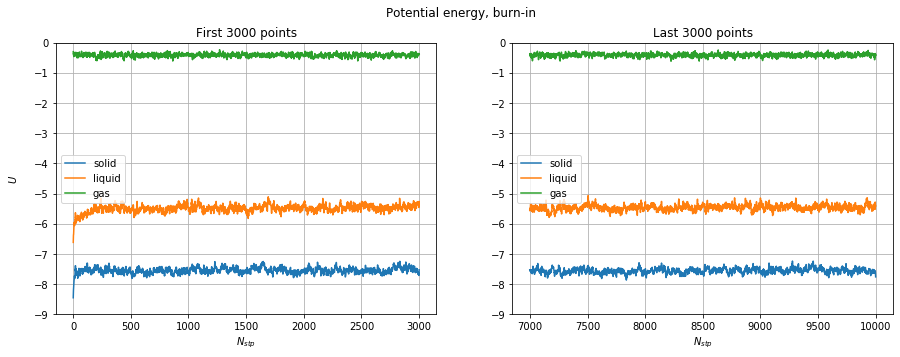

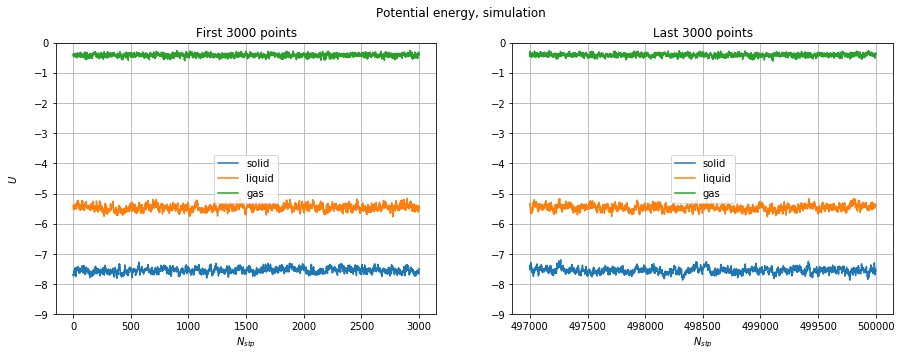

In [3]:
graph_burn("epot",True)
graph_burn("epot",False)

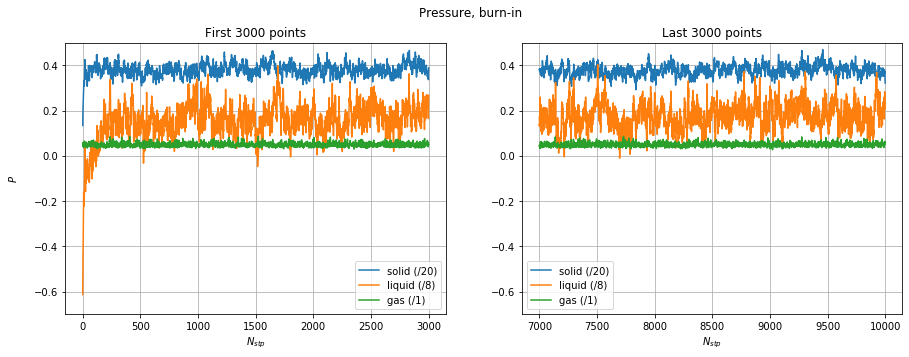

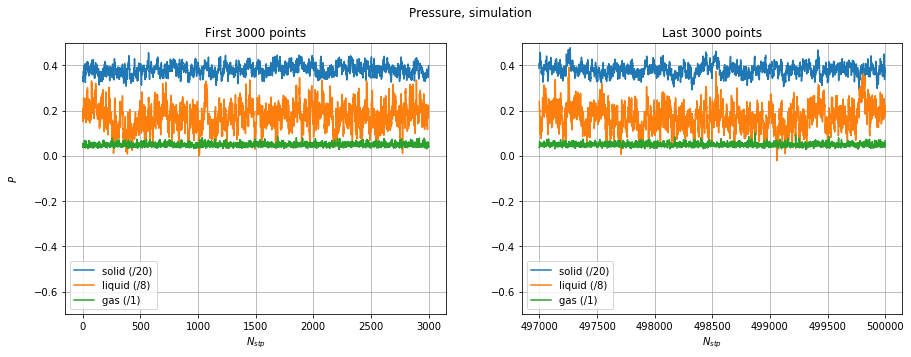

In [4]:
graph_burn("pres",True)
graph_burn("pres",False)

Dai grafici risulta evidente che la fase di equilibrazione è del tutto completata all'inizio della vera e propria simulazione. Anzi, anche solo qualche centinaio di passi è sufficiente per la prima fase di burn-in.

Il passo successivo è stato quello di studiare, con gli $M$ dati della simulazione, l'andamento con la distanza temporale $t$ delle funzioni di autocorrelazione ${Ac}(t)$ delle due grandezze termodinamiche di interesse, allo scopo di stimare da esse i tempi di autocorrelazione $t_c$ delle varie catene e dare una stima approssimativa della dimensione minima dei blocchi.

A causa del numero finito di dati l'errore statistico sul calcolo di ${Ac}(t)$ aumenta al crescere di $t$ (più distanti tra loro devono essere presi i dati, meno possibilità di scelta si hanno). In linea di principio quindi può essere utile eseguire il calcolo con tutti i dati campionati. In realtà però $t_c$ risulta molto più piccolo del numero totale di passi $M$, e quindi i $t$ di interesse sono al massimo dell'ordine del centinaio di steps. Per motivi di efficienza ho quindi scelto di utilizzare nei calcoli seguenti solo i primi $t_{max}=10^4$ passi, ritenendo già così trascurabili, almeno qualitativamente, gli errori commessi sul calcolo del tempo tipico di autocorrelazione. Questo sarà stimato qualitativamente vedendo in quanto tempo $Ac(t)$ passa dal valore unitario iniziale a valori sostanzialmente nulli, che indicano distanze temporali abbastanza grandi perché le configurazioni campionate siano completamente scorrelate.

In [5]:
long=500           #t in graph, but I use tmax=20*long to reduce near tmax fluctuations (not all data for efficiency)
t,tmax=np.arange(long),20*long

def autocorr(state,meas):   #state can be "solid","liquid","gas"; meas can be "epot", "pres"
    data=np.genfromtxt('results/output.'+state+'.'+meas+'.ist',skip_header=1,max_rows=tmax,usecols=(1))
    summ=[np.zeros(long) for i in range(3)]
    summ[0]=[sum(data[0:tmax-tt]*data[tt:tmax]) for tt in t]
    summ[1]=[sum(data[0:tmax-tt]) for tt in t]
    summ[2]=[sum(data[tt:tmax]) for tt in t]
    for i in range(3): summ[i]/=tmax-t
    a=1./tmax*sum(data**2)-(1./tmax*sum(data))**2
    print("...", end=" ")
    return (summ[0]-summ[1]*summ[2])/a

In [6]:
print("computing energy autocorrelation...", end=" ")
Ac_ene=(autocorr('solid','epot'),autocorr('liquid','epot'),autocorr('gas','epot'))
print(); print("computing pressure autocorrelation...", end=" ")
Ac_pres=(autocorr('solid','pres'),autocorr('liquid','pres'),autocorr('gas','pres'))
Ac=(Ac_ene,Ac_pres)

computing energy autocorrelation... ... ... ... 
computing pressure autocorrelation... ... ... ... 

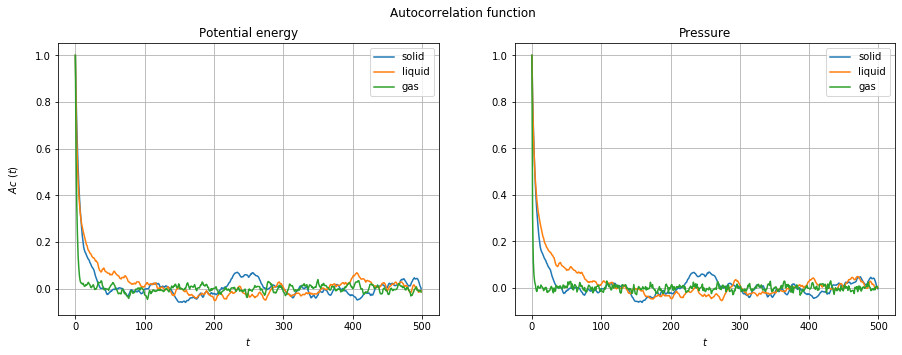

In [7]:
pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    for j in range(3): pl.plot(t,Ac[i][j],label=lab_state[j])
    pl.legend(loc='best')
    pl.xlabel('$t$')
    if i==0: pl.ylabel('$Ac\ (t)$',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Autocorrelation function')
pl.show()

Entro circa $t_c \sim 100$ passi le configurazioni campionate diventano sostanzialmente scorrelate. Per un corretto utilizzo del blocking method i blocchi dovranno essere grandi a sufficienza perché gli effetti di autocorrelazine siano percepiti solo sui loro "bordi", in modo che le medie di blocco siano scorrelate tra loro. A questo punto una scelta abbastanza prudente per il numero di step per blocco potrebbe essere $L \sim 10\ t_c \sim 1000$.

Riporto sotto in un grafico la differenza tra le due funzioni di autocorrelazione.

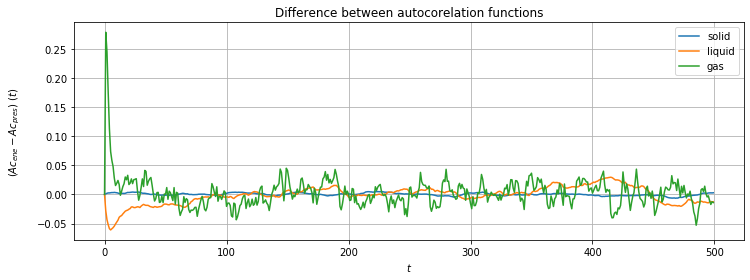

In [8]:
pl.figure(figsize=(12,4))
for j in range(3): pl.plot(t,Ac[0][j]-Ac[1][j],label=lab_state[j])
pl.legend(loc='best')
pl.xlabel('$t$')
pl.ylabel('$(Ac_{ene}-Ac_{pres})\ (t)$',labelpad=15)
pl.title('Difference between autocorelation functions')
pl.grid(True)
pl.show()

I due risultati sono simili ma non uguali, e si assomigliano sempre più all'aumento di $t_{max}$. Come ci si poteva aspettare la funzione di correlazione, e quindi il tempo tipico $t_c$ che deve trascorrere per avere configurazioni non correlate, non dipende dalla particolare grandezza misurata sugli stati ed utilizzata per la stima di $Ac(t)$. La differenza tra le due funzioni sembra infatti legata solo a fenomeni di incertezza statistica (le fluttuazioni qui sono dello stesso ordine di grandezza di quelle del grafico precedente, se non più piccole).

Ho ripreso quindi ad utilizzare tutti gli $M=10^5$ dati della simulazione post-equilibrazione per stimare l'andamento dell'incertezza statistica dei risultati finali (blocking method) di $U/N$ e di $P$ all'aumentare della dimensione $L$ dei blocchi. Il numero totale di dati utilizzati è sempre stato mantenuto lo stesso (fanno eccezione lo studio di quei casi in cui $L$ non è un divisore esatto di $M$, per i quali il numero di passi è stato ridotto al più grande $M'$ possibile tale che $M' \!\!\!\! \mod\!\!\! L = 0$; tale riduzione è del tutto trascurabile ai fini della nostra analisi).

In [9]:
stepL,maxL=(10,50,100),(200,2000,5000)   #L=10 min, L=5000 max
t_end=int(5e5); tmax=np.arange(0)        #number of total steps t_end=M
L=np.arange(stepL[0],maxL[0]+1,stepL[0]) #different jumps for different ranges of L
for i in range(2): L=np.append(L,np.arange(maxL[i]+stepL[i+1],maxL[i+1]+1,stepL[i+1]))
tmax=(t_end//L)*L                        #tmax=M'
nnL=len(L)

def Nblock_err(state,meas):             #function for the error graph
    data=np.genfromtxt('results/output.'+state+'.'+meas+'.ist',skip_header=1,usecols=(1))
    aveBlk=[sum(data[x:x+L[i]])/L[i]   for i in range(nnL)   for x in range(0,tmax[i],L[i])] #averages for errors exstimation
    ave2Blk=[x**2 for x in aveBlk]

    errEne=np.zeros(nnL)
    done=0
    for i in range(nnL):
        nblk=int(tmax[i]/L[i])
        summ=sum(aveBlk[done:done+nblk])/nblk
        sum2=sum(ave2Blk[done:done+nblk])/nblk
        errEne[i]=np.sqrt((nblk+1.)*(sum2-summ*summ))/nblk
        done+=nblk
    print("...", end=" ")
    return errEne

In [10]:
scale_g=(4,200)
print("computing energy uncertainties...", end=" ")
err_ene=(Nblock_err('solid','epot'),Nblock_err('liquid','epot'),scale_g[0]*Nblock_err('gas','epot'))
print(); print("computing pressure uncertainties...", end=" ")
err_pres=(Nblock_err('solid','pres'),Nblock_err('liquid','pres'),scale_g[1]*Nblock_err('gas','pres'))
err=(err_ene,err_pres)

computing energy uncertainties... ... ... ... 
computing pressure uncertainties... ... ... ... 

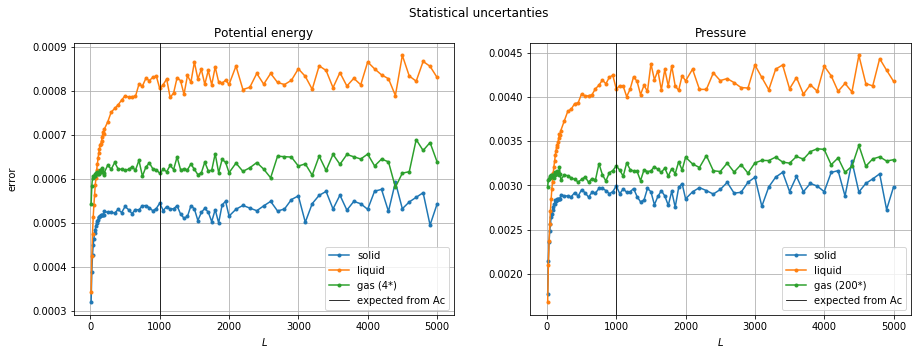

In [11]:
label=lab_state.copy()

pl.figure(figsize=(15,5))
for i in range(2):
    pl.subplot(1,2,i+1)
    label[2]=lab_state[2]+' ('+str(scale_g[i])+'*)'
    for j in range(3): pl.plot(L,err[i][j],marker='.',label=label[j])
    pl.axvline(x=1000,color='k',linewidth=0.8,label='expected from Ac')
    pl.legend(loc='best')
    pl.xlabel('$L$')
    if i==0: pl.ylabel('error',labelpad=15)
    pl.title(title[i])
    pl.grid(True)
pl.suptitle('Statistical uncertanties')
pl.show()

Per dimensioni dei blocchi troppo piccole l'incertezza statistica è sottostimata: le medie di blocco sono correlate tra loro, quindi l'utilizzo del CLT e della conseguente formula standard per la deviazione standard della media produce una sottostima dell'incertezza $\sigma_{err}$. All'aumentare di $L$ sono sempre meno i dati che, essendo sui "bordi", sono correlati statisticamente tra un blocco e l'altro. Quando i blocchi sono sufficientemente grandi questo porta sostanzialmente all'indipendenza statistica tra le varie medie di blocco: da questo punto in poi il CLT è applicabile e la stima dell'incertezza come deviazione standard della media delle medie di blocco affidabile. Al crescere ulteriore di $L$ la situazione non cambia (a parità di dati generati) e la stima, affidabile, satura ad un certo valore statisticamente costante (all'aumentare ulteriore della dimensione dei blocchi le singole medie diventano più affidabili, ma la diminuzione del numero delle stesse controbilancia la tendenza di $\sigma_{err}$ a diminuire maggiormente).

Dal grafico ho stimato che una buona scelta potesse essere $L=2000$. $L$ più alti non aumentano la precisione ottenuta, ma nell'ottica di volere un particolare numero di blocchi $N_{blk}$ fissato (e $M=N_{blk} L$ determinato di conseguenza) accrescono il tempo macchina necessario alla simulazione.

### Esercizio 07.2

A questo punto si è preso $L=2000$ e $N_{blk}=20$ e, dopo un'equilibrazione di $N_{burn}=3000$ step, si sono ottenute col blocking method le medie progressive per l'energia interna e la pressione e i risultati finali per la *funzione di distribuzione radiale* $ g(r)$, che esprime la probabilità di trovare una qualunque coppia distanza $r$ in rapporto alla stessa probabilità che si avrebbe nel caso di un gas ideale, in cui le particelle sono tra loro indipendenti. L'espressione che è stata utilizzata per la stima di questa distribuzione è

$$ g(r) = \frac{1}{\rho N \Delta V(r)} \left\langle 2 \sum_{i>j=1}^N \delta \left[ r - |\vec{r}_i - \vec{r}_j| \right] \right\rangle$$

con $\rho$ densità media del sistema e $\Delta V(r) = 4/3 \ \pi \left[ (r+dr)^3 - r^3\right]$ volume della calotta sferica infinitesima di raggio $r$.\
La funzione $g(r)$ è stata studiata suddividendo l'intervallo $[0,L_{box}/2]$ di distanze possibili (in pbc) tra due particelle all'interno del box di simulazione in $N_{bin}=100$ bin e mediando il numero di particelle associate ad ognuno di essi secondo la distribuzione di Boltzmann

$$ p(\vec{r}_1,\dots,\vec{r}_N) = \frac{e^{-\beta \ U(\vec{r}_1,\dots,\vec{r}_N)}}{Z} $$

campionata sempre attraverso l'algoritmo di Metropolis.

I grafici seguenti mostrano la $g(r)$ calcolata nei tre stati. Per i risultati delle altre due grandezze termodinamiche si veda invece direttamente l'<font face="Courier">esercizio04</font>, in cui le misure ottenute sono direttamente convertite in unità SI per il caso dell'Argon.

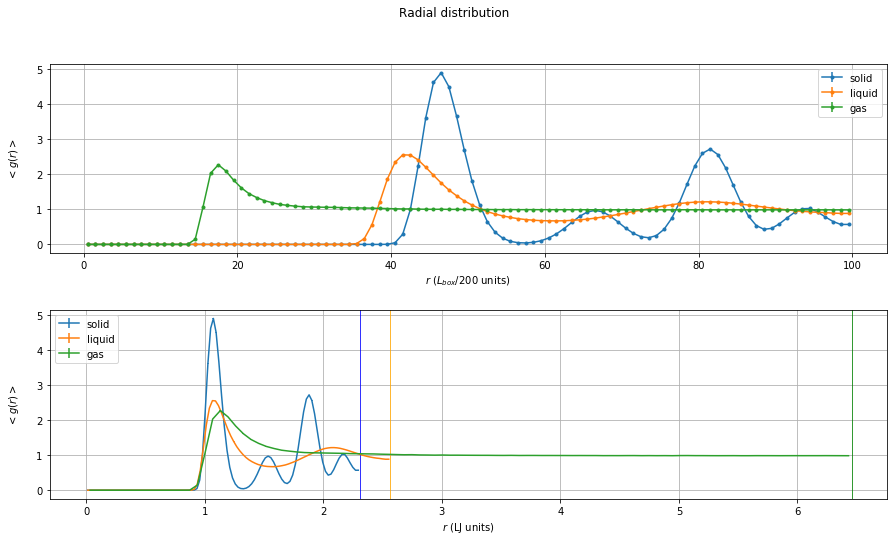

In [12]:
L_s,binS=np.genfromtxt('results/output.solid.gave.0',max_rows=1)             # Number of throws in each block, bin size
L_l,binL=np.genfromtxt('results/output.liquid.gave.0',max_rows=1) 
L_g,binG=np.genfromtxt('results/output.gas.gave.0',max_rows=1) 
gS=np.genfromtxt('results/output.solid.gave.0',skip_header=1,names='nbin,res,err')
gL=np.genfromtxt('results/output.liquid.gave.0',skip_header=1,names='nbin,res,err')
gG=np.genfromtxt('results/output.gas.gave.0',skip_header=1,names='nbin,res,err')
        
L=(L_s,L_l,L_g); bin_width=(binS,binL,binG)
gofr=[gS,gL,gG]; colors=('blue','orange','green')
for i in range(3): gofr[i]['nbin']+=1./2.      

pl.figure(figsize=(15,8))
for k in range (2):
    pl.subplot(2,1,k+1)
    for i in range(3):
        if k==0: pl.errorbar(gofr[i]['nbin'],gofr[i]['res'],yerr=gofr[i]['err'],marker='.',label=lab_state[i])
        else:
            gofr[i]['nbin']*=bin_width[i]
            pl.errorbar(gofr[i]['nbin'],gofr[i]['res'],yerr=gofr[i]['err'],label=lab_state[i])
            pl.axvline(x=100*bin_width[i],color=colors[i],linewidth=0.8)
    pl.legend(loc='best')
    if k==0: pl.xlabel('$r\ (L_{box}/200$ units)')
    else: pl.xlabel('$r$ (LJ units)')
    pl.ylabel('$<g(r)>$',labelpad=15)
    pl.grid(True)
pl.subplots_adjust(hspace=0.3)
pl.suptitle('Radial distribution')
pl.show()

gAr=gofr.copy();

Il primo grafico, in cui $r$ è preso in unità di $L_{box}/200$, permette facilmente di vedere che tutte le distribuzioni tendono ad oscillare e poi ad assestarsi attorno a $g(r)=1$ al crescere di $r$. Nel secondo grafico $r$ è convertito in unità di Lennard-Jones, e questo fa sì che risulti evidente il sostanziale annullamnento di tutte le $g(r)$ per $r \lesssim 1\ \sigma$. Qui le linee verticali indicano il raggiungimento delle rispettive distanze $L_{box}/2$ .\
Entrambe le osservazioni sono coerenti con la forma dell'interazione di Lennard-Jones. L'andamento del potenziale di interazione come $r^{-12}$ per piccoli $r$ impedisce infatti alle particelle di avvicinarsi a distanze troppo piccole, mentre il suo tendere a $0$ come $r^{-6}$ per grandi $r$ fa sì che a grandi distanze le particelle siano sostanzialmente indipendenti tra loro e che quindi la distribuzione radiale diventi equivalente a quella del gas ideale (sistema disordinato). Questo secondo effetto si vede particolarmente bene nel caso del gas, in cui le particelle sono mediamente più distanti. Nel caso del solido invece, dove la densità è maggiore, le distanze medie tra le particelle sono ancora troppo piccole perché si possa vedere chiaramente la convergenza di $g(r)$ a $1$ e il sistema rimane invece ordinato in tutto il box di simulazione.

### Esercizio 07.3

Il sistema in esame era già stato analizzato coi metodi della *dinamica molecolare* come *ensemble microcanonico* ($N$, $V$, $E$ fissati) nell'<font face="Courier">esercitazione04</font>. Mentre qui si generano configurazioni MC secondo la distribuzione di Boltzmann a $T$ fissata e se ne ricavano le medie termiche delle grandezze di interesse, là si risolvevano le equazioni del moto a $E$ fissata con l'algoritmo di Verlet. Nell'ottica di un confronto tra i due tipi di analisi, ho inserito il calcolo della $g(r)$ anche nella libreria <font face="Courier">MolDyn_NVE</font>. Grazie all'ipotesi di ergodicità l'implementazione del calcolo di $g(r)$ è del tutto identica.

### Esercizio 07.4

Ho infine studiato coi metodi descritti fin qui un sistema di atomi di Argon interagenti secondo un potenziale di Lennard-Jones. I risultati MC per $U/N$ e $P$ e $g(r)$ sono quelli dell'<font face="Courier">esercizio07.2</font> correttamente convertiti in unità SI.

In [13]:
#costants for conversion between LJ units and SI units
sig=0.34                            #sigma [nm]
kB,eps_kB=1.98064852e-23,120.       #Boltzmann constant [J/K], eps/kB [K]
eps=eps_kB*kB;                      #eps [J]

EpotS=np.genfromtxt('results/output.solid.epot.0',usecols=(0,2,3),names='nblk,res,err')
EpotL=np.genfromtxt('results/output.liquid.epot.0',usecols=(0,2,3),names='nblk,res,err')
EpotG=np.genfromtxt('results/output.gas.epot.0',usecols=(0,2,3),names='nblk,res,err')
PS=np.genfromtxt('results/output.solid.pres.0',usecols=(0,2,3),names='nblk,res,err')
PL=np.genfromtxt('results/output.liquid.pres.0',usecols=(0,2,3),names='nblk,res,err')
PG=np.genfromtxt('results/output.gas.pres.0',usecols=(0,2,3),names='nblk,res,err')
obs=(EpotS,PS,EpotL,PL,EpotG,PG)

for i in range(6):
    obs[i]['res']*=eps; obs[i]['err']*=eps    #energy conversion
    if i%2==1: obs[i]['res']*=1e18/(sig**3); obs[i]['err']*=1e18/(sig**3) #pressure conversion

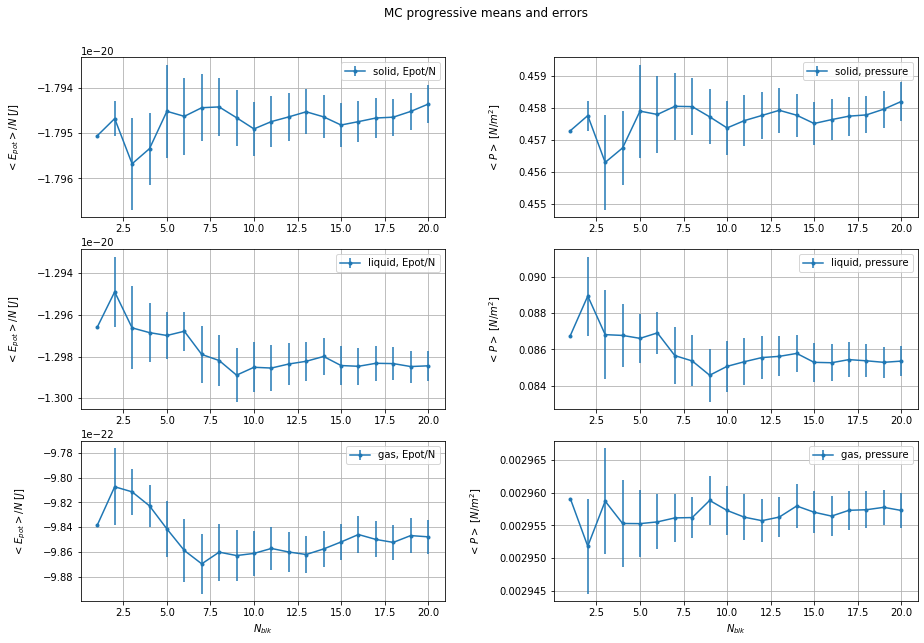

In [14]:
obs_label=(', Epot/N',', pressure'); y_lab=['$<E_{pot}>/N\ [J]$','$<P>\ [N/m^2]$']

pl.figure(figsize=(15,10))
for i in range(6):
    pl.subplot(3,2,i+1)
    pl.errorbar(obs[i]['nblk'],obs[i]['res'],yerr=obs[i]['err'],marker='.',label=lab_state[i//2]+obs_label[i%2])
    pl.legend(loc='best')
    if i>3: pl.xlabel('$N_{blk}$')
    pl.ylabel(y_lab[i%2],labelpad=15)
    pl.grid(True)
pl.suptitle("MC progressive means and errors", y=0.95)
pl.subplots_adjust(wspace=0.3)
pl.show()

Ho infine calcolato la $g(r)$ coi metodi della dinamica molecolare per un sistema di particelle di Argon a energia interna fissata in modo da avere delle temperature medie il più possibili corrispondenti a quelle imposte per l'ensamble canonico. Ho utilizzato un numero totale di passi $N_{step}=2\times10^4$, suddivisi in $N_{blk}=20$ blocchi, dopo una serie di $N_{ign}=10$ (per il gas anche $N_{ign}=20$ e $N_{ign}=30$) ripartenze, ognuna da $N_{eq}=1000$ step, per equilibrare la temperatura a quella richiesta nei tre casi.

I grafici seguenti riportano il confronto tra questi ultimi risultati e quelli ottenuti in precedenza con i metodi MC.

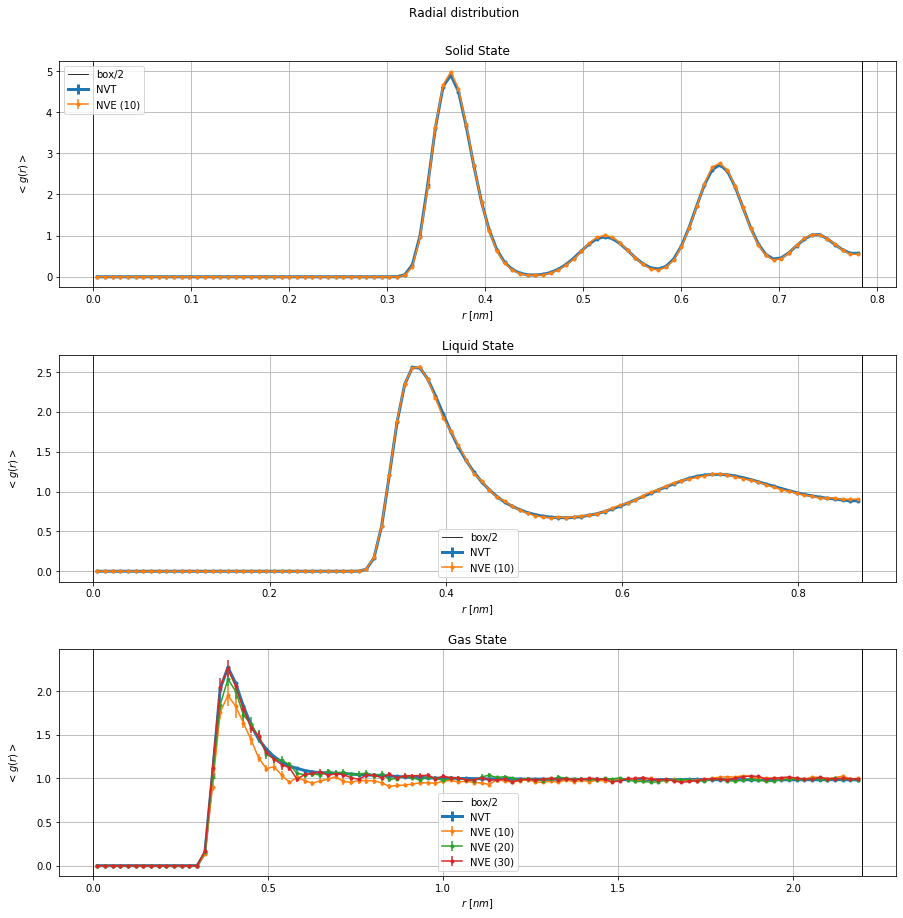

In [15]:
NVE_L_s,NVE_binS=np.genfromtxt('results/output.solid.gave.10.NVE',max_rows=1)             # Number of throws in each block, bin size
NVE_L_l,NVE_binL=np.genfromtxt('results/output.liquid.gave.10.NVE',max_rows=1) 
NVE_L_g,NVE_binG=np.genfromtxt('results/output.gas.gave.10.NVE',max_rows=1) 
NVE_gS=np.genfromtxt('results/output.solid.gave.10.NVE',skip_header=1,names='nbin,res,err')
NVE_gL=np.genfromtxt('results/output.liquid.gave.10.NVE',skip_header=1,names='nbin,res,err')
NVE_gG=np.genfromtxt('results/output.gas.gave.10.NVE',skip_header=1,names='nbin,res,err')
g20=np.genfromtxt('results/output.gas.gave.20.NVE',skip_header=1,names='nbin,res,err')
g30=np.genfromtxt('results/output.gas.gave.30.NVE',skip_header=1,names='nbin,res,err')    

L_NVE=(NVE_L_s,NVE_L_l,NVE_L_g); bin_width_NVE=(NVE_binS,NVE_binL,NVE_binG)
gofr_NVE=(NVE_gS,NVE_gL,NVE_gG,g20,g30);
for i in range(3): gofr_NVE[i]['nbin']=(gofr_NVE[i]['nbin']+1./2.)*bin_width_NVE[i]*sig
for i in (3,4): gofr_NVE[i]['nbin']=(gofr_NVE[i]['nbin']+1./2.)*bin_width_NVE[2]*sig

title_State=('Solid','Liquid','Gas')
pl.figure(figsize=(15,15))
for i in range(3):
    pl.subplot(3,1,i+1)
    pl.errorbar(gofr[i]['nbin']*sig,gofr[i]['res'],yerr=gofr[i]['err'],marker='.',linewidth=3,label='NVT')
    pl.errorbar(gofr_NVE[i]['nbin'],gofr_NVE[i]['res'],yerr=gofr_NVE[i]['err'],marker='.',label='NVE (10)')
    if i==2:
        pl.errorbar(gofr_NVE[i+1]['nbin'],gofr_NVE[i+1]['res'],yerr=gofr_NVE[i+1]['err'],marker='.',label='NVE (20)')
        pl.errorbar(gofr_NVE[i+2]['nbin'],gofr_NVE[i+2]['res'],yerr=gofr_NVE[i+2]['err'],marker='.',label='NVE (30)')
    pl.axvline(x=0,color='k',linewidth=0.8,label='box/2')
    pl.axvline(x=100*bin_width[i]*sig,color='k',linewidth=0.8)
    pl.axvline(x=100*bin_width_NVE[i]*sig,color='k',linewidth=0.8)
    pl.legend(loc='best')
    pl.xlabel('$r \ [nm]$')
    pl.ylabel('$<g(r)>$',labelpad=15)
    pl.title(title_State[i]+' State')
    pl.grid(True)
pl.subplots_adjust(hspace=0.3)
pl.suptitle('Radial distribution', y=0.93)
pl.show()

Avendo fissato la $T$ media del programma di *molecular dynamics* pari a quella dell'ensamble canonico si ottengono nei due casi delle funzioni di distrubuzione radiale praticamente equivalenti. In sostanza i due tipi di algoritmo, completamente diversi tra loro, producono entrambi delle configurazioni in cui la correlazione spaziale tra le particelle è del tutto analoga. Per osservare questo nel gas sono state necessarie $N_{ign}=30$ ripartenze per far sì che il sistema si assestasse correttamente sulla temperatura desiderata.